# Compute transformation due to SW from GOES data

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import pandas as pd

### Load in era/merra ds

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

#load in era and merra surf fluxes
era_jm2 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))

#hflux = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/heat_fluxes.zarr'))
#sw_rad = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/rad.zarr'))
#merra_hrly = xr.merge([hflux, sw_rad])

merra_hrly = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean.zarr'))

In [3]:
merra_hrly

<xarray.Dataset> Size: 125MB
Dimensions:   (time: 7296, lat: 19, lon: 45)
Coordinates:
  * lat       (lat) float64 152B 22.0 22.5 23.0 23.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 58kB 2023-01-01T00:30:00 ... 2023-10-31T2...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 25MB dask.array<chunksize=(1, 19, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

In [4]:
era_jm2

<xarray.Dataset> Size: 2GB
Dimensions:    (latitude: 37, longitude: 113, time: 6485)
Coordinates:
  * latitude   (latitude) float32 148B 31.0 30.75 30.5 30.25 ... 22.5 22.25 22.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 52kB 2023-01-01 ... 2023-09-28T04:00:00
Data variables:
    slhf       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    sshf       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    ssr        (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    str        (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
    strd       (time, latitude, longitude) float64 217MB dask.array<chunksize=(1622, 10, 29), meta=np.ndarray>
Attributes:
    long_name:  Sea surface temperature
    units:      K

In [5]:
#convert ERA ds to W/m^2 and both ds to daily
era_hrly = (era_jm2.sortby('latitude') / (60*60))
era = era_hrly.resample(time='D').mean()
sst_era = (era_jm2.sst-273.15).resample(time='D').mean()
merra_unsliced = merra_hrly.resample(time='D').mean()
merra = merra_unsliced.sel(time=slice(None, '2023-09-28'))
sst_merra = (merra.TSKINWTR-273.15)

In [6]:
era = xr.merge([era.drop_vars('sst'), sst_era])

In [7]:
merra = xr.merge([merra.drop_vars('TSKINWTR'), sst_merra])

In [8]:
era.coords

Coordinates:
  * latitude   (latitude) float32 148B 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28

In [9]:
merra.coords

Coordinates:
  * lat      (lat) float64 152B 22.0 22.5 23.0 23.5 24.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28

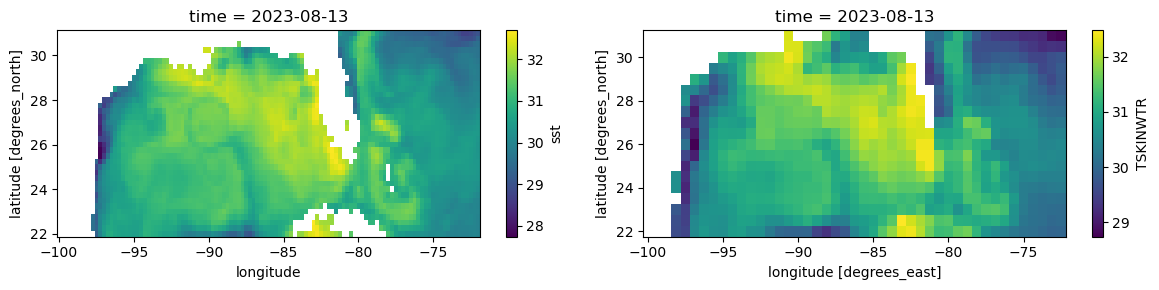

In [15]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,3))

era.sst.sel(time='2023-08-13', method='nearest').plot(ax=ax0)
merra.TSKINWTR.sel(time='2023-08-13', method='nearest').plot(ax=ax1)
plt.tight_layout();

## Run histograms but with GOES sw
- Create new grid objects with GOES' coarser resolution
- Run histogram

In [16]:
goes_t = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/sw_ds.zarr'))
goes = goes_t.assign_coords({'time':goes_t.t}).swap_dims({'t':'time'}).drop_vars('t')

In [17]:
goes

<xarray.Dataset> Size: 304MB
Dimensions:                          (time: 37665, lat: 18, lon: 56)
Coordinates:
    dsr_product_wavelength           float32 4B ...
  * lat                              (lat) float64 144B 30.75 30.25 ... 22.25
    lat_image                        float32 4B ...
  * lon                              (lon) float64 448B -99.75 -99.25 ... -72.25
    lon_image                        float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    quantitative_solar_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * time                             (time) datetime64[ns] 301kB 2019-12-05T1...
Data variables:
    DQF                              (time, lat, lon) float32 152MB dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
    DSR                              (time, lat, lon) float32 152MB dask.array<chunksize=(37665, 18, 56), meta=np.ndarray>
Attributes: (12/21)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_ID:             FM1
    iso_series_metadata_id:    de00d810-b013-11e1-afa6-0800200c9a66
    ...                        ...
    project:                   GOES
    scene_id:                  Full Disk
    spatial_resolution:        50km at nadir
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The Downward Shortwave Radiation: Surface prod...
    title:                     ABI L2 Downward Shortwave Radiation: Surface

In [18]:
sw_hrly = goes.DSR.sel(time=slice('2023-01', '2023-09-28'))
sw = sw_hrly.sortby('lat').resample(time='D').mean()

In [19]:
sw

<xarray.DataArray 'DSR' (time: 271, lat: 18, lon: 56)> Size: 1MB
dask.array<transpose, shape=(271, 18, 56), dtype=float32, chunksize=(271, 18, 56), chunktype=numpy.ndarray>
Coordinates:
    dsr_product_wavelength           float32 4B ...
  * lat                              (lat) float64 144B 22.25 22.75 ... 30.75
    lat_image                        float32 4B ...
  * lon                              (lon) float64 448B -99.75 -99.25 ... -72.25
    lon_image                        float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    quantitative_solar_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * time                             (time) datetime64[ns] 2kB 2023-01-01 ......
Attributes:
    ancillary_variables:  DQF
    cell_methods:         retrieval_local_zenith_angle: point (good or degrad...
    grid_mapping:         goes_lat_lon_projection
    long_name:            ABI L2+ Downward Shortwave Radiation: Surface
    resolution:           lon: 0.5 degree lat: 0.5 degree
    standard_name:        surface_downwelling_shortwave_flux_in_air
    units:                W m-2

In [20]:
sw.coords

Coordinates:
    dsr_product_wavelength           float32 4B ...
  * lat                              (lat) float64 144B 22.25 22.75 ... 30.75
    lat_image                        float32 4B ...
  * lon                              (lon) float64 448B -99.75 -99.25 ... -72.25
    lon_image                        float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    quantitative_solar_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * time                             (time) datetime64[ns] 2kB 2023-01-01 ......

In [21]:
era.isel(longitude=slice(1, -1), latitude=slice(1, -1)).coords

Coordinates:
  * latitude   (latitude) float32 140B 22.25 22.5 22.75 ... 30.25 30.5 30.75
  * longitude  (longitude) float32 444B -99.75 -99.5 -99.25 ... -72.5 -72.25
  * time       (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28

In [22]:
merra.isel(lon=slice(1, None), lat=slice(1, -1)).coords

Coordinates:
  * lat      (lat) float64 136B 22.5 23.0 23.5 24.0 24.5 ... 29.0 29.5 30.0 30.5
  * lon      (lon) float64 352B -99.38 -98.75 -98.12 ... -73.75 -73.12 -72.5
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28

In [23]:
merra.SWGNTWTR.isel(lon=slice(1, None), lat=slice(1, -1)).shape

(271, 17, 44)

In [24]:
sw.shape

(271, 18, 56)

In [25]:
import xesmf as xe

#regrid ERA surf fluxes to GOES sw resolution and use it in histogram
regridder = xe.Regridder(era.isel(longitude=slice(1, -1), latitude=slice(1, -1)), 
                         sw,
                         method='bilinear')

era_new_grid = regridder(era.isel(longitude=slice(1, -1), latitude=slice(1, -1)))

#regrid MERRA surf fluxes to GOES sw resolution and use it in histogram
regridder = xe.Regridder(merra.isel(lon=slice(1, None), lat=slice(1, -1)), 
                         sw,
                         method='bilinear')

merra_new_grid = regridder(merra.isel(lon=slice(1, None), lat=slice(1, -1)))

In [26]:
sw.shape

(271, 18, 56)

In [27]:
era_new_grid.ssr.shape

(271, 18, 56)

In [28]:
merra_new_grid.SWGNTWTR.shape

(271, 18, 56)

In [29]:
mask_e = era_new_grid.sst[0].isnull()
mask_m = merra_new_grid.TSKINWTR[0].isnull()

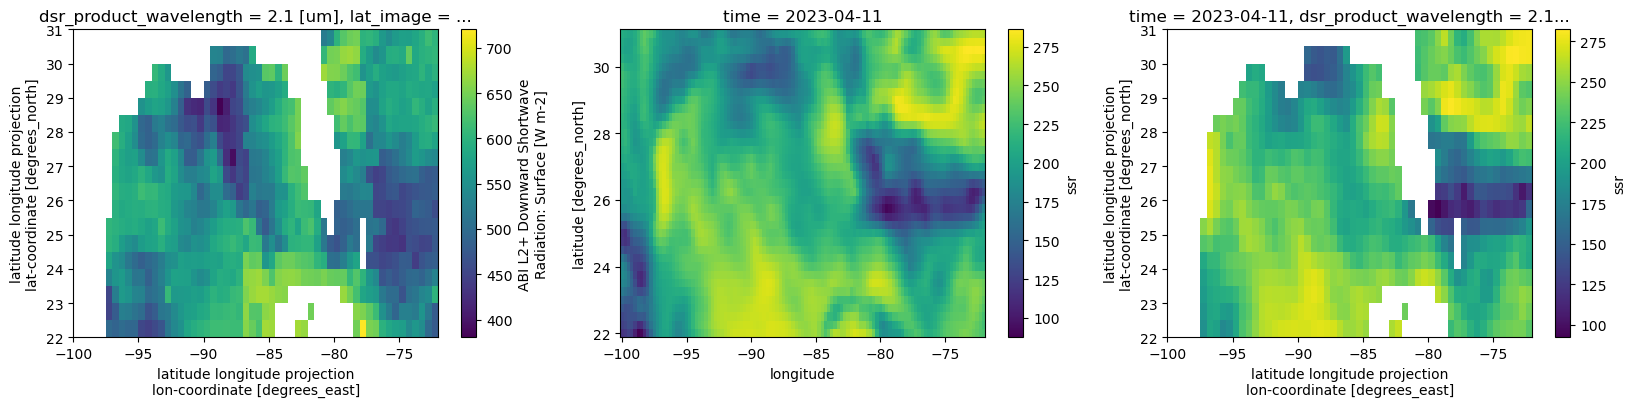

In [30]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20, 4))
sw.where(~mask_e)[100].plot(ax=ax0)
era.ssr[100].plot(ax=ax1)
era_new_grid.ssr.where(~mask_e)[100].plot(ax=ax2)

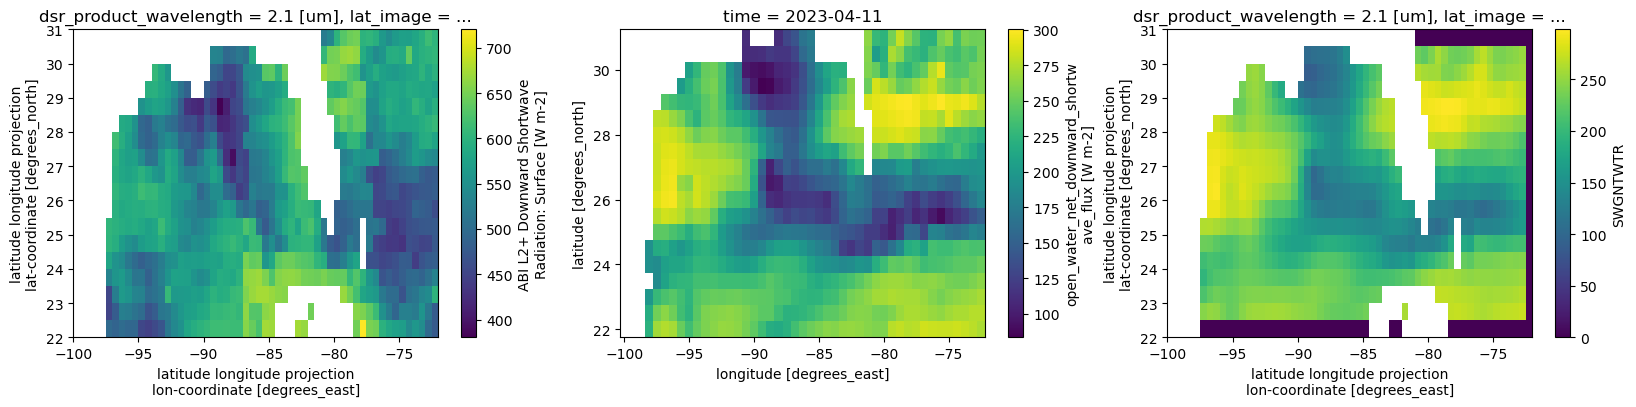

In [31]:
#use mask_e instead, since MERRA has cut offs due to coords not aligning exactly like ERA/GOES
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20, 4))
sw.where(~mask_e)[100].plot(ax=ax0)
merra.SWGNTWTR[100].plot(ax=ax1)
merra_new_grid.SWGNTWTR[100].where(~mask_e).plot(ax=ax2)

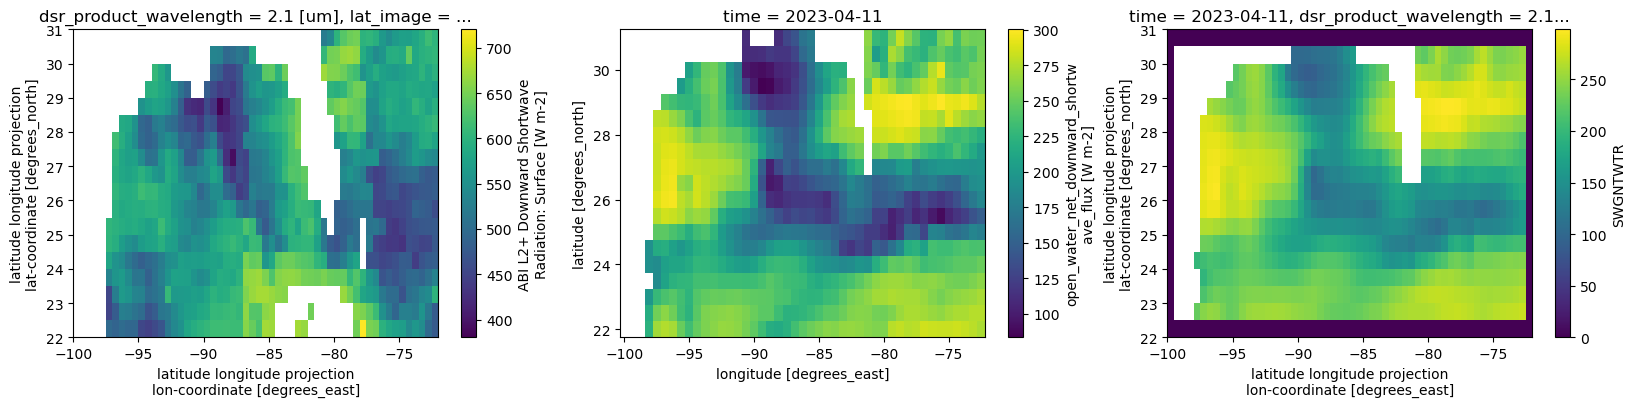

In [32]:
#plotting w/o era mask on last suplot
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20, 4))
sw.where(~mask_e)[100].plot(ax=ax0)
merra.SWGNTWTR[100].plot(ax=ax1)
merra_new_grid.SWGNTWTR[100].plot(ax=ax2)

In [33]:
#assign GOES sw to each ds
merra_new_grid['SWGNTWTR'] = sw
era_new_grid['ssr'] = sw

In [34]:
merra_new_grid

<xarray.Dataset> Size: 5MB
Dimensions:                          (time: 271, lat: 18, lon: 56)
Coordinates:
  * time                             (time) datetime64[ns] 2kB 2023-01-01 ......
    dsr_product_wavelength           float32 4B ...
    lat_image                        float32 4B ...
    lon_image                        float32 4B ...
    quantitative_local_zenith_angle  float32 4B ...
    quantitative_solar_zenith_angle  float32 4B ...
    retrieval_local_zenith_angle     float32 4B ...
    retrieval_solar_zenith_angle     float32 4B ...
  * lat                              (lat) float64 144B 22.25 22.75 ... 30.75
  * lon                              (lon) float64 448B -99.75 -99.25 ... -72.25
Data variables:
    EFLUXWTR                         (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
    HFLUXWTR                         (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
    LWGNTWTR                         (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
    SWGNTWTR                         (time, lat, lon) float32 1MB dask.array<chunksize=(271, 18, 56), meta=np.ndarray>
    TSKINWTR                         (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [35]:
#drop the non dim-coords
merra_ng = merra_new_grid.drop_vars(list(merra_new_grid.coords)[1:-2])
era_ng = era_new_grid.drop_vars(list(era_new_grid.coords)[1:-2])

In [36]:
era_ng

<xarray.Dataset> Size: 14MB
Dimensions:  (time: 271, lat: 18, lon: 56)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat      (lat) float64 144B 22.25 22.75 23.25 23.75 ... 29.75 30.25 30.75
  * lon      (lon) float64 448B -99.75 -99.25 -98.75 ... -73.25 -72.75 -72.25
Data variables:
    slhf     (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    sshf     (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    ssr      (time, lat, lon) float32 1MB dask.array<chunksize=(271, 18, 56), meta=np.ndarray>
    ssrd     (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    str      (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    strd     (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    sst      (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [37]:
merra_ng

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 271, lat: 18, lon: 56)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat       (lat) float64 144B 22.25 22.75 23.25 23.75 ... 29.75 30.25 30.75
  * lon       (lon) float64 448B -99.75 -99.25 -98.75 ... -73.25 -72.75 -72.25
Data variables:
    EFLUXWTR  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 1MB dask.array<chunksize=(271, 18, 56), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 17, 44), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [38]:
ds_full_e = generate_grid_ds(era_ng, {'X':'lon', 'Y':'lat'})
ds_full_m = generate_grid_ds(merra_ng, {'X':'lon', 'Y':'lat'})

In [39]:
grid_e = xgcm.Grid(ds_full_e, periodic='X')
grid_m = xgcm.Grid(ds_full_m, periodic='X')

In [40]:
ds_full_e

<xarray.Dataset> Size: 14MB
Dimensions:   (time: 271, lat: 18, lon: 56, lon_left: 56, lat_left: 18)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat       (lat) float64 144B 22.25 22.75 23.25 23.75 ... 29.75 30.25 30.75
  * lon       (lon) float64 448B -99.75 -99.25 -98.75 ... -73.25 -72.75 -72.25
  * lon_left  (lon_left) float64 448B -100.0 -99.5 -99.0 ... -73.5 -73.0 -72.5
  * lat_left  (lat_left) float64 144B 22.0 22.5 23.0 23.5 ... 29.5 30.0 30.5
Data variables:
    slhf      (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    sshf      (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    ssr       (time, lat, lon) float32 1MB dask.array<chunksize=(271, 18, 56), meta=np.ndarray>
    ssrd      (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    str       (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    strd      (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
    sst       (time, lat, lon) float64 2MB dask.array<chunksize=(135, 10, 29), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [41]:
grid_e

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center

In [42]:
def deg_2_m(grid_obj, ds_obj, lat, lon):
    #calculating meters per latitudinal & longitudinal degree
    earth_radius = 6.371e6
    earth_circumference = 2*np.pi*earth_radius
    meters_per_degree = earth_circumference / 360
    meters_per_degree
    
    #converting lat from degrees to meters
    delta_lat = grid_obj.diff(ds_obj[f'{lat}'], 'Y', boundary='fill', fill_value=np.nan)
    dy = delta_lat * meters_per_degree
    delta_lat_l = grid_obj.diff(ds_obj[f'{lat}_left'], 'Y', boundary='fill', fill_value=np.nan)
    dy_l = delta_lat_l * meters_per_degree

    #converting degrees lon to lon [meters] (pinching at the poles)
    delta_lon = grid_obj.diff(ds_obj[f'{lon}'], 'X')#, boundary_discontinuity=360)
    dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}']))
    delta_lon_l = grid_obj.diff(ds_obj[f'{lon}_left'], 'X')#, boundary_discontinuity=360)
    dx_l = delta_lon_l * meters_per_degree * np.cos(np.deg2rad(ds_obj[f'{lat}_left']))
    
    elements = xr.merge([dx.rename('dx'), dx_l.rename('dx_l'), 
                          dy.rename('dy'), dy_l.rename('dy_l')])
    
    return (elements)

In [43]:
cell_elements_e = deg_2_m(grid_e, ds_full_e, 'lat', 'lon')
cell_elements_m = deg_2_m(grid_m, ds_full_m, 'lat', 'lon')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


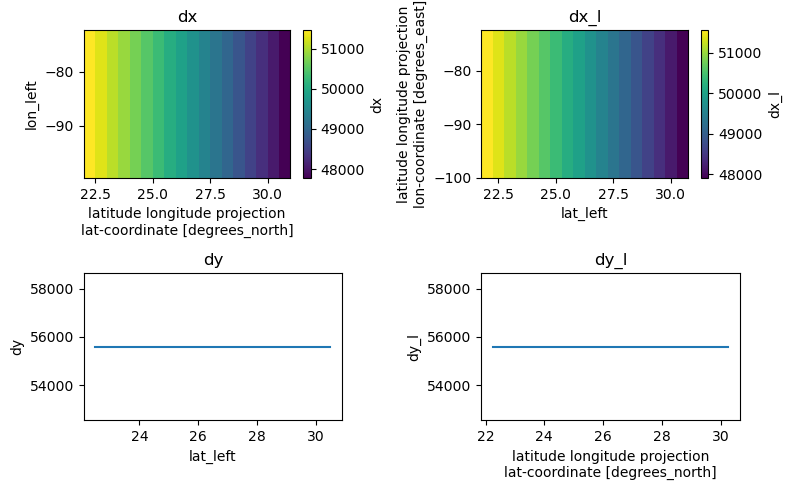

In [44]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_e.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_e.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_e.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_e.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

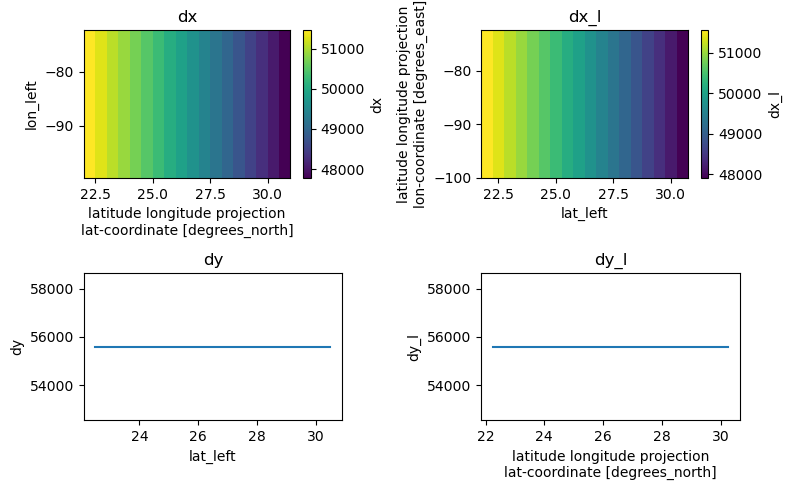

In [45]:
fig, ax = plt.subplots(2,2, figsize=(8,5))
cell_elements_m.dx[1:].plot(ax=ax[0,0])
ax[0,0].set_title('dx')
cell_elements_m.dx_l[:-1].plot(ax=ax[0,1])
ax[0,1].set_title('dx_l')
cell_elements_m.dy.plot(ax=ax[1,0])
ax[1,0].set_title('dy')
cell_elements_m.dy_l.plot(ax=ax[1,1])
ax[1,1].set_title('dy_l')
plt.tight_layout();

#### Create mask

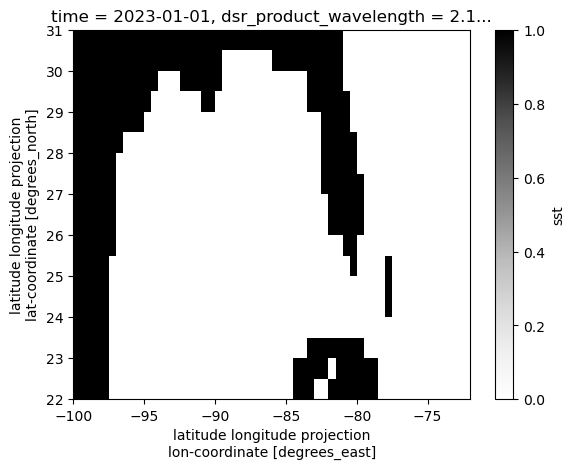

In [46]:
cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_e.plot(cmap=cmap);

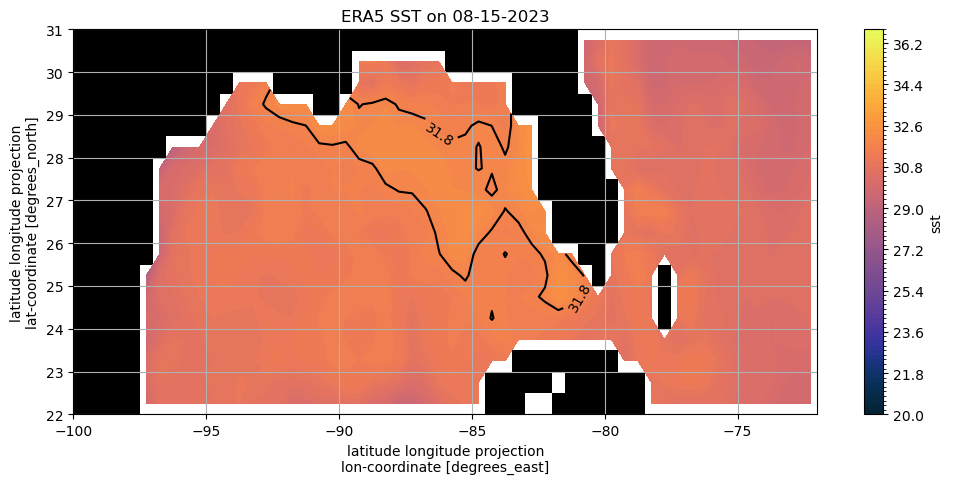

In [47]:
plt.figure(figsize=(12,5))

cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)
mask_e.plot(cmap=cmap, add_colorbar=False)

era_ng.sst.sel(time='2023-08-15', method='nearest').plot.contourf(levels=np.arange(20, 37, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = era_ng.sst.sel(time='2023-08-15', method='nearest').plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('ERA5 SST on 08-15-2023');

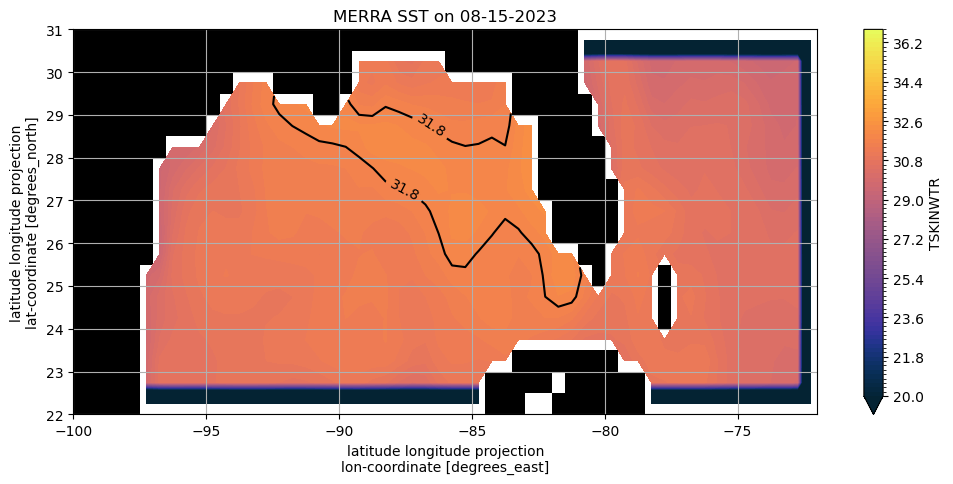

In [48]:
plt.figure(figsize=(12,5))

cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)

mask_e.plot(cmap=cmap, add_colorbar=False)
merra_ng.TSKINWTR.sel(time='2023-08-15', method='nearest').where(~mask_e).plot.contourf(levels=np.arange(20, 37, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = merra_ng.TSKINWTR.sel(time='2023-08-15', method='nearest').where(~mask_e).plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('MERRA SST on 08-15-2023');

In [51]:
merra_ng.TSKINWTR[:,1:-1,:]

<xarray.DataArray 'TSKINWTR' (time: 271, lat: 16, lon: 56)> Size: 971kB
dask.array<getitem, shape=(271, 16, 56), dtype=float32, chunksize=(1, 16, 44), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat      (lat) float64 128B 22.75 23.25 23.75 24.25 ... 29.25 29.75 30.25
  * lon      (lon) float64 448B -99.75 -99.25 -98.75 ... -73.25 -72.75 -72.25

In [62]:
merra_ng['TSKINWTR_masked'] = merra_ng.TSKINWTR.where(merra_ng.TSKINWTR!=0)

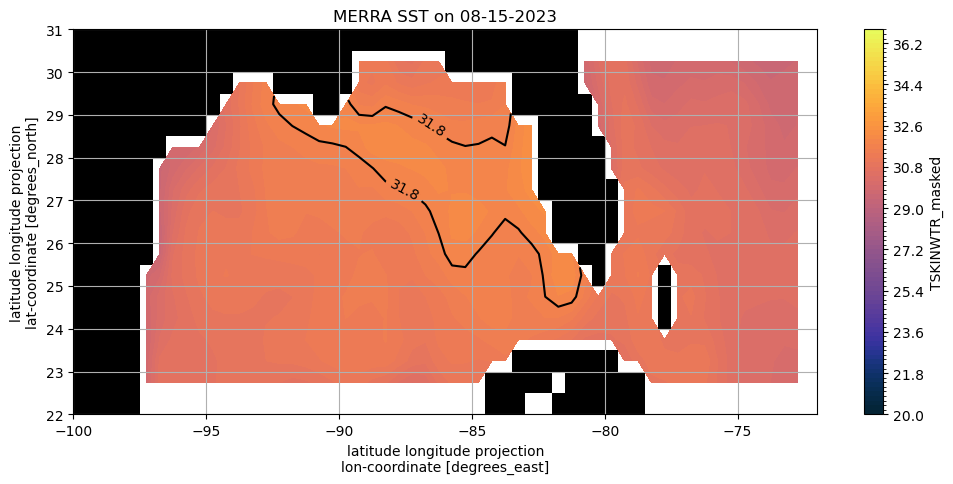

In [63]:
plt.figure(figsize=(12,5))

cmap = plt.colormaps.get_cmap("Greys")
cmap.set_bad('red', 1.)

mask_e.plot(cmap=cmap, add_colorbar=False)
merra_ng.TSKINWTR_masked.sel(time='2023-08-15', method='nearest').where(~mask_e).plot.contourf(levels=np.arange(20, 37, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = merra_ng.TSKINWTR_masked.sel(time='2023-08-15', method='nearest').where(~mask_e).plot.contour(levels=[31.8], colors='k')
plt.clabel(c)
plt.grid()
plt.title('MERRA SST on 08-15-2023');

# Budget

In [64]:
dx_interp_e = grid_e.interp(cell_elements_e.dx_l, 'Y')
area_e = dx_interp_e * cell_elements_e.dy_l

dx_interp_m = grid_m.interp(cell_elements_m.dx_l, 'Y')
area_m = dx_interp_m * cell_elements_m.dy_l

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


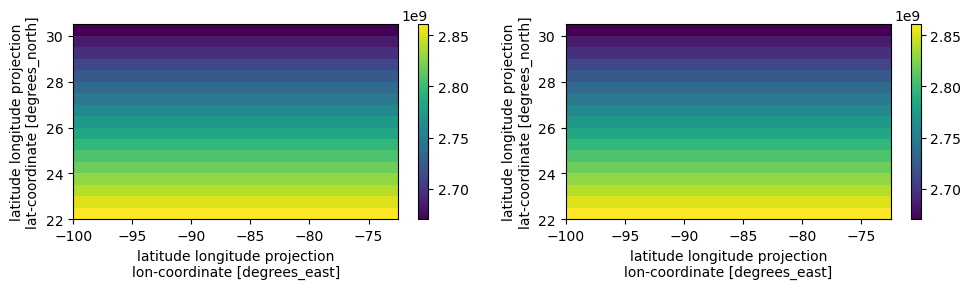

In [66]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
area_e[:-1, :-1].T.plot(ax=ax0)
area_m[:-1, :-1].T.plot(ax=ax1)
plt.tight_layout();

In [67]:
Cp = heat_capacity_cp = 3.994e3 #J/kg/˚C
rho = 1027 #kg/m^3 #according to Harte Research Institute(https://www.harteresearch.org/sites/default/files/inline-files/3.pdf)

#(W/m^2) x 1/Cp x 1/rho x area
era_weighted = (era_ng.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                area_e.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s
merra_weighted = (merra_ng.isel(lon=slice(None, -1), lat=slice(None, -1)) * 
                  area_m.isel(lon=slice(None, -1), lat=slice(None, -1)) * (1/Cp) * (1/rho)) #˚C m^3/s

In [68]:
era_weighted.coords

Coordinates:
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat      (lat) float64 136B 22.25 22.75 23.25 23.75 ... 29.25 29.75 30.25
  * lon      (lon) float64 440B -99.75 -99.25 -98.75 ... -73.75 -73.25 -72.75

In [69]:
merra_weighted.coords

Coordinates:
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat      (lat) float64 136B 22.25 22.75 23.25 23.75 ... 29.25 29.75 30.25
  * lon      (lon) float64 440B -99.75 -99.25 -98.75 ... -73.75 -73.25 -72.75

In [70]:
merra_ng.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1)).coords

Coordinates:
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat      (lat) float64 136B 22.25 22.75 23.25 23.75 ... 29.25 29.75 30.25
  * lon      (lon) float64 440B -99.75 -99.25 -98.75 ... -73.75 -73.25 -72.75

In [71]:
era_ng.sst.isel(lon=slice(None, -1), lat=slice(None, -1)).coords

Coordinates:
  * time     (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * lat      (lat) float64 136B 22.25 22.75 23.25 23.75 ... 29.25 29.75 30.25
  * lon      (lon) float64 440B -99.75 -99.25 -98.75 ... -73.75 -73.25 -72.75

In [73]:
#drop the non dim-coords adopted by GOES ds
mask_e = mask_e.drop_vars(list(mask_e.coords)[:-2])

In [76]:
mask_e[:-1].coords

Coordinates:
  * lat      (lat) float64 136B 22.25 22.75 23.25 23.75 ... 29.25 29.75 30.25
  * lon      (lon) float64 448B -99.75 -99.25 -98.75 ... -73.25 -72.75 -72.25

In [77]:
delta_theta = 0.1
theta_bins = np.arange(20, 38, delta_theta)

def hist_func(sst, ds, variable):
    hist = histogram(sst.where(~mask_e[:-1]).rename('theta'), bins=[theta_bins],
                    weights=ds[variable].where(~mask_e[:-1]).fillna(0.),
                    dim=['lon', 'lat']) / delta_theta
    return hist #m^3/s (Sv)

In [97]:
sst_e = era_ng.sst.isel(lon=slice(None, -1), lat=slice(None, -1))
sst_m = merra_ng.TSKINWTR.isel(lon=slice(None, -1), lat=slice(None, -1))
sst_mm = merra_ng.TSKINWTR_masked.isel(lon=slice(None, -1), lat=slice(None, -1))

era_hist_uncut = xr.merge([hist_func(sst_e,
                                     era_weighted, 
                                     var).rename('omega_'+var) 
                     for var in list(era_weighted)[:-1]])
merra_hist = xr.merge([hist_func(sst_m,
                                 merra_weighted, 
                                 var).rename('omega_'+var)
                      for var in list(merra_weighted)[:-2]])
merra_hist_m = xr.merge([hist_func(sst_mm,
                                 merra_weighted, 
                                 var).rename('omega_'+var)
                      for var in list(merra_weighted)[:-2]])

In [98]:
era_hist = era_hist_uncut.drop_vars(['omega_ssrd', 'omega_strd'])
merra_hist['omega_HFLUXWTR'] = -merra_hist['omega_HFLUXWTR']
merra_hist['omega_EFLUXWTR'] = -merra_hist['omega_EFLUXWTR']

#Check to see if masking tskinwtr affects hist results
merra_hist_m['omega_HFLUXWTR'] = -merra_hist_m['omega_HFLUXWTR']
merra_hist_m['omega_EFLUXWTR'] = -merra_hist_m['omega_EFLUXWTR']

In [99]:
era_hist

<xarray.Dataset> Size: 2MB
Dimensions:     (time: 271, theta_bin: 179)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * theta_bin   (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.65 37.75 37.85
Data variables:
    omega_slhf  (time, theta_bin) float64 388kB dask.array<chunksize=(135, 179), meta=np.ndarray>
    omega_sshf  (time, theta_bin) float64 388kB dask.array<chunksize=(135, 179), meta=np.ndarray>
    omega_ssr   (time, theta_bin) float64 388kB dask.array<chunksize=(135, 179), meta=np.ndarray>
    omega_str   (time, theta_bin) float64 388kB dask.array<chunksize=(135, 179), meta=np.ndarray>

In [100]:
merra_hist

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 271, theta_bin: 179)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2023-01-01 ... 2023-09-28
  * theta_bin       (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.75 37.85
Data variables:
    omega_EFLUXWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>
    omega_HFLUXWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>
    omega_LWGNTWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>
    omega_SWGNTWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>

In [101]:
merra_hist_m

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 271, theta_bin: 179)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2023-01-01 ... 2023-09-28
  * theta_bin       (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.75 37.85
Data variables:
    omega_EFLUXWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>
    omega_HFLUXWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>
    omega_LWGNTWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>
    omega_SWGNTWTR  (time, theta_bin) float64 388kB dask.array<chunksize=(1, 179), meta=np.ndarray>

In [102]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [103]:
era_hist.load()

<xarray.Dataset> Size: 2MB
Dimensions:     (time: 271, theta_bin: 179)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2023-01-01 2023-01-02 ... 2023-09-28
  * theta_bin   (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.65 37.75 37.85
Data variables:
    omega_slhf  (time, theta_bin) float64 388kB 0.0 1.564e+04 ... 0.0 0.0
    omega_sshf  (time, theta_bin) float64 388kB 0.0 8.036e+04 ... 0.0 0.0
    omega_ssr   (time, theta_bin) float64 388kB 0.0 5.006e+06 ... 0.0 0.0
    omega_str   (time, theta_bin) float64 388kB 0.0 -5.485e+05 ... 0.0 0.0

In [104]:
merra_hist.load()

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 271, theta_bin: 179)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2023-01-01 ... 2023-09-28
  * theta_bin       (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.75 37.85
Data variables:
    omega_EFLUXWTR  (time, theta_bin) float64 388kB -2.424e+05 ... -0.0
    omega_HFLUXWTR  (time, theta_bin) float64 388kB 4.122e+03 1.565e+04 ... -0.0
    omega_LWGNTWTR  (time, theta_bin) float64 388kB -1.205e+06 ... 0.0
    omega_SWGNTWTR  (time, theta_bin) float64 388kB 7.176e+06 3.05e+06 ... 0.0

In [105]:
merra_hist_m.load()

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 271, theta_bin: 179)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2023-01-01 ... 2023-09-28
  * theta_bin       (theta_bin) float64 1kB 20.05 20.15 20.25 ... 37.75 37.85
Data variables:
    omega_EFLUXWTR  (time, theta_bin) float64 388kB -2.424e+05 ... -0.0
    omega_HFLUXWTR  (time, theta_bin) float64 388kB 4.122e+03 1.565e+04 ... -0.0
    omega_LWGNTWTR  (time, theta_bin) float64 388kB -1.205e+06 ... 0.0
    omega_SWGNTWTR  (time, theta_bin) float64 388kB 7.176e+06 3.05e+06 ... 0.0

<Figure size 2500x500 with 0 Axes>

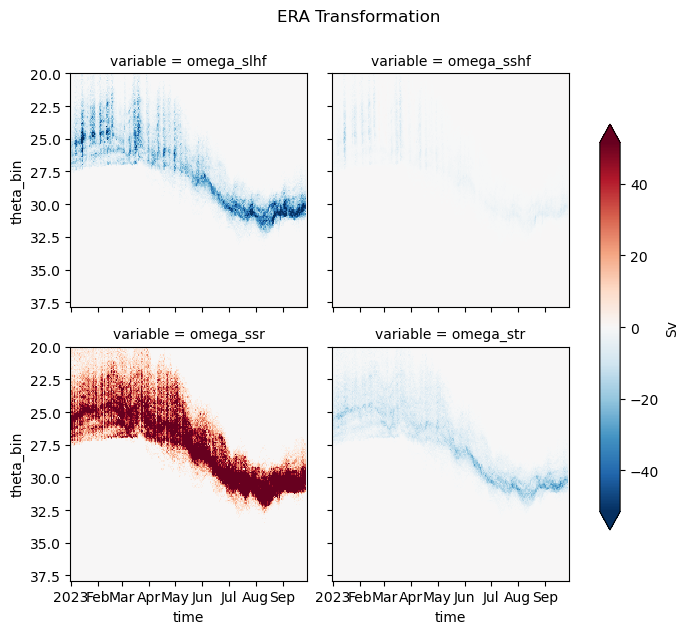

In [106]:
plt.figure(figsize=(25,5))
(era_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('ERA Transformation', y=1.05);

<Figure size 2500x500 with 0 Axes>

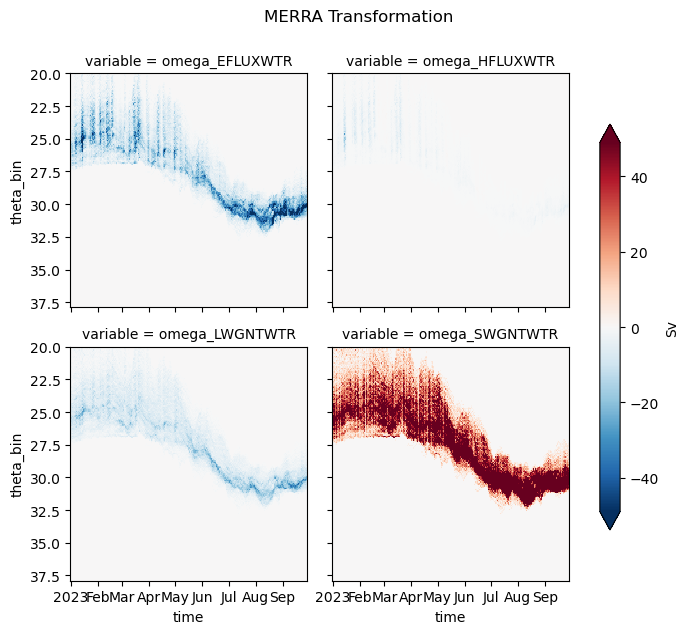

In [107]:
plt.figure(figsize=(25,5))
(merra_hist/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('MERRA Transformation', y=1.05);

<Figure size 2500x500 with 0 Axes>

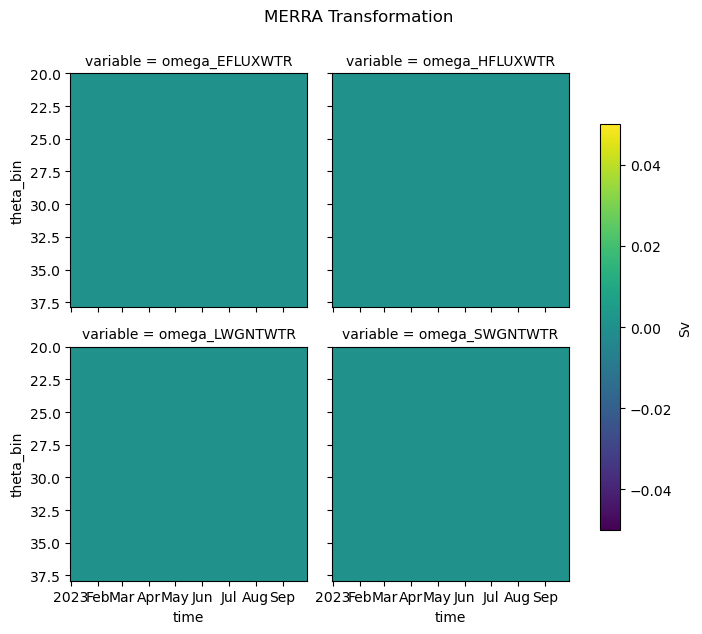

In [111]:
#no difference in masking - only upload merra_hist and era_hist
plt.figure(figsize=(25,5))
((merra_hist-merra_hist_m)/1e6).to_array().plot(col='variable', col_wrap=2, x='time', 
                               yincrease=False, robust=True, 
                               cbar_kwargs={'shrink': 0.8, 'label':'Sv'})
plt.suptitle('MERRA Transformation', y=1.05);

In [112]:
one_plt_era = era_hist.sel(theta_bin=31.8, method='nearest')
one_plt_merra = merra_hist.sel(theta_bin=31.8, method='nearest')

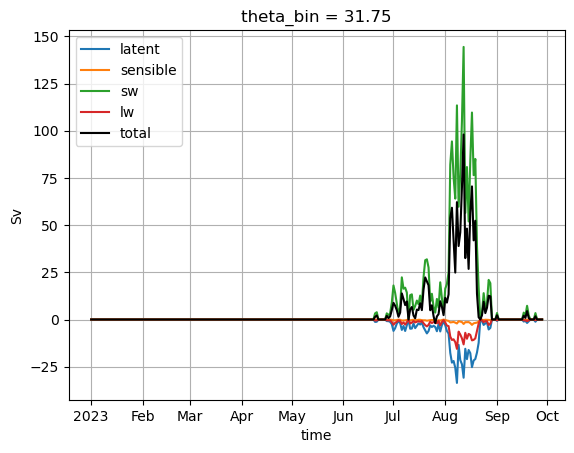

In [113]:
(one_plt_era.omega_slhf/1e6).plot(label='latent')
(one_plt_era.omega_sshf/1e6).plot(label='sensible')
(one_plt_era.omega_ssr/1e6).plot(label='sw')
(one_plt_era.omega_str/1e6).plot(label='lw')
(one_plt_era/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
plt.grid();

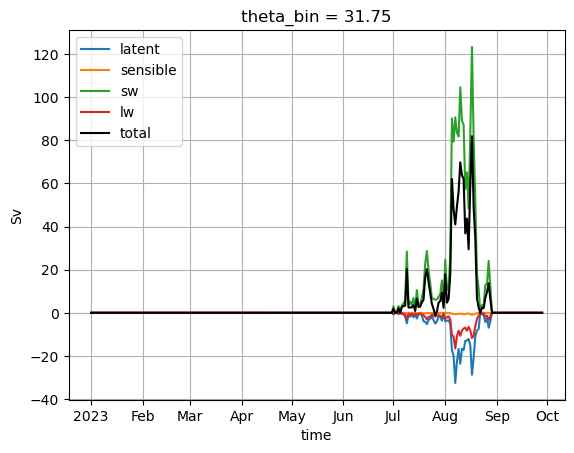

In [114]:
(one_plt_merra.omega_EFLUXWTR/1e6).plot(label='latent')
(one_plt_merra.omega_HFLUXWTR/1e6).plot(label='sensible')
(one_plt_merra.omega_SWGNTWTR/1e6).plot(label='sw')
(one_plt_merra.omega_LWGNTWTR/1e6).plot(label='lw')
(one_plt_merra/1e6).to_array().sum('variable').plot(label='total', color='k')
plt.legend()
plt.ylabel('Sv')
plt.grid();